In [ ]:
from notebooks import *

In [ ]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(skimr))
suppressMessages(library(ggmap))
suppressMessages(library(rnaturalearth))

In [ ]:
display(
    len(xc.metadata),
    sum(xc.metadata.downloaded),
    df_summary(xc.metadata.sample(n=1000, random_state=0)).T,
)

•

399859

31727

min                                                               25%                                           50%                                                              75%                                        max
               dtype          sizeof len  count nunique mean        std                                                                                                                                                                                                                                                                                 
downloaded     bool           24328  1000 1000  2       NaN         NaN                                                False                                                             False                                         False                                                            False                                       True
species        category       52674  1000 970   765     NaN         NaN                                                 None                                                              YRTI                                          BNOR                                                             BLRE                                       PTWH
id             int64          28000  1000 1000  1000     212105.140 118901.356                                           612                                                            108961                                        217118                                                           312830                                     417407
sci_name       category       67589  1000 1000  781     NaN         NaN                                Melanerpes santacruzi                                             Pogoniulus bilineatus                             Oriolus chinensis                                             Phoenicurus ochruros                             Vidua macroura
com_name       category       66599  1000 1000  781     NaN         NaN                               Tucuman Mountain Finch                                          Yellow-rumped Tinkerbird                            Black-naped Oriole                                                   Black Redstart                          Pin-tailed Whydah
subspecies     object         51013  1000 1000  201     NaN         NaN                                                                                                                                                                                                                                                                         zaleptus
recordist      object         65083  1000 1000  347     NaN         NaN                                              AM AMSA                                                        Erik Roels                            Libor Vaicenbacher                                                    Peter Boesman                              Étienne Leroy
country        object         57204  1000 1000  91      NaN         NaN                                            Argentina                                                          Colombia                                   Ivory Coast                                                            Spain                                   Zimbabwe
locality       object         93244  1000 1000  899     NaN         NaN                         57°59'50.65'N   24°40'3.64'E  Estación Biológica Las Cruces, San Vito de Coto Brus, Puntarenas                                     Menagesha  Ryedale District (near  Helperthorpe), North Yorkshire, England  龙桥步行街站 (near  Chengdu Shi), Sichuan Sheng
lat            float64        24000  1000 947   867      18.477     27.398                                             -48.7                                                             -2.05                                          15.9                                                             43.6                         

In [ ]:
# Slow (~30s)
display(
    df_summary(xc.metadata).T,
    xc.metadata.sample(100, random_state=0).sort_values('id'),
)

[skip]

In [ ]:
robjects.globalenv['species_levels'] = robjects.vectors.StrVector(xc.metadata.species.cat.categories)
robjects.globalenv['quality_levels'] = robjects.vectors.StrVector(xc.metadata.quality.cat.categories)
xc_metadata_ = (xc.metadata
    # [:1000]  # Faster dev
    # Filter down to the cols we're currently using in R, to avoid a ~30s bottleneck in %Rpush
    [['downloaded', 'species', 'lat', 'lng', 'quality', 'date']]
    .pipe(df_cat_to_str)  # Cats fail to convert
   .astype({'date': 'str'})  # Datetimes fail to convert
)

%Rpush xc_metadata_

In [ ]:
%%R
xc_metadata <- (xc_metadata_
    %>% mutate(
        species = factor(species, levels = species_levels),
        quality = factor(quality, levels = quality_levels),
        date = as.Date(date)
    )
)
# print(skim(xc_metadata))  # Slow, big, but informative when needed
# xc_metadata %>% sample_n(5)

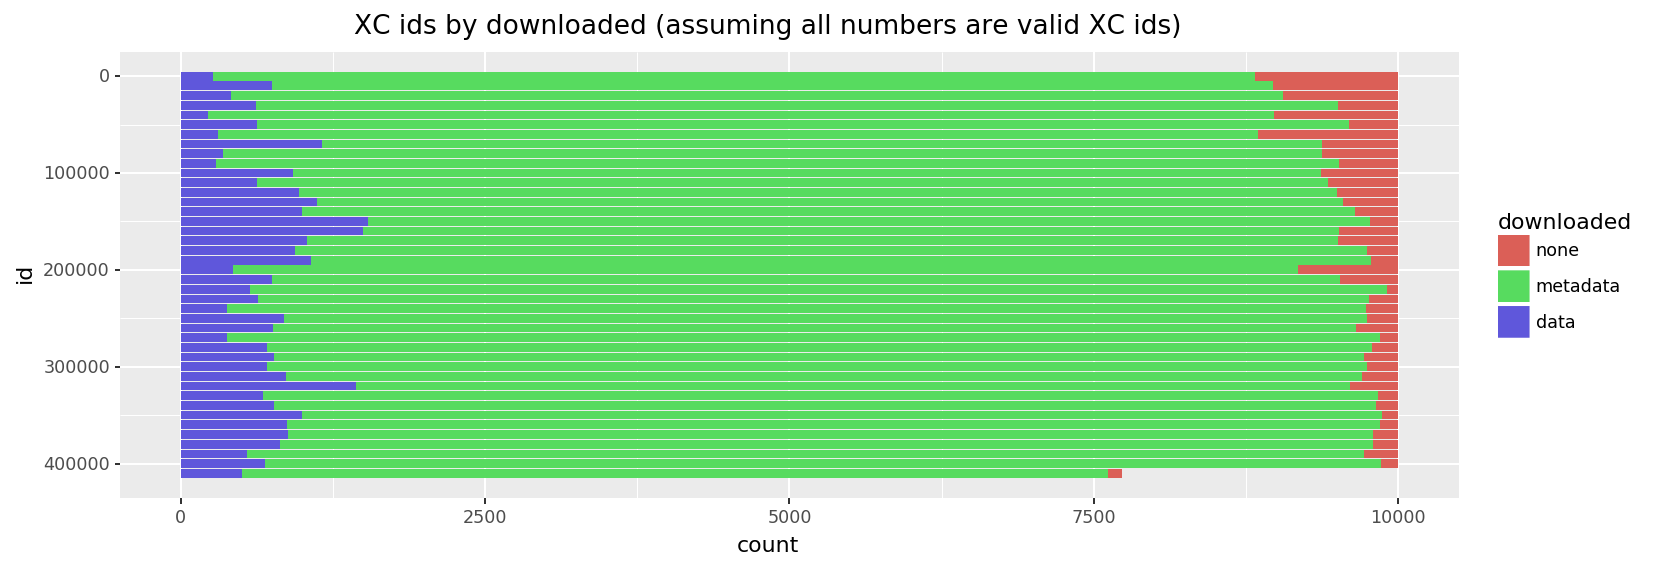

<ggplot: (-9223372036564871694)>

In [ ]:
bin_size = 10_000
bin_f = lambda x: (x // bin_size) * bin_size
(
    pd.concat(axis=0, objs=[
        DF({'downloaded': 'data',     'count': bin_f(xc.metadata[lambda df: df.downloaded].id).value_counts()}),
        DF({'downloaded': 'metadata', 'count': bin_f(xc.metadata[lambda df: ~df.downloaded].id).value_counts()}),
        DF({'downloaded': 'none',     'count': bin_f(xc.unsaved_ids).value_counts()}),
    ])
    .reset_index().rename(columns={'index': 'id'})
    .pipe(df_ordered_cat, downloaded=['none', 'metadata', 'data'])
    .pipe(ggplot, aes(x='id', y='count', fill='downloaded'))
    + geom_bar(stat='identity', width=bin_size*.9)
    + coord_flip()
    + scale_x_reverse()
    + theme_figsize('inline_short')
    + ggtitle('XC ids by downloaded (assuming all numbers are valid XC ids)')
)

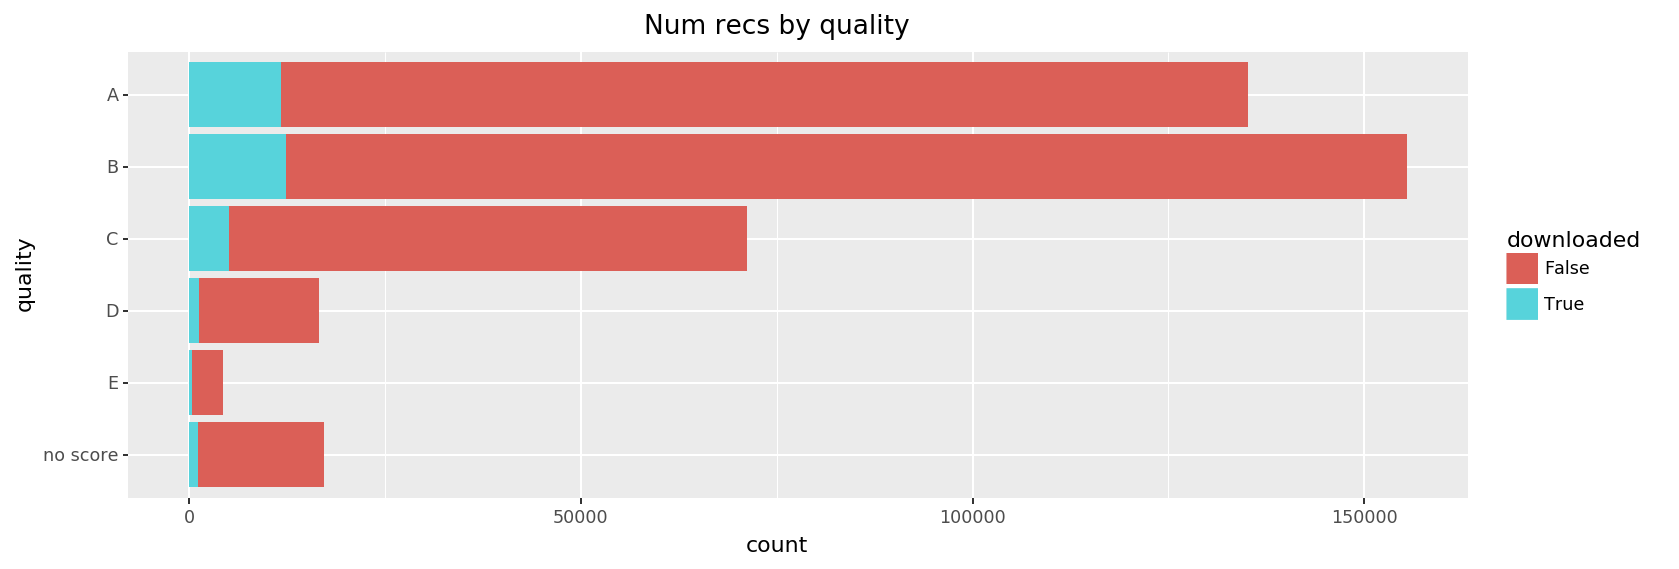

<ggplot: (289915733)>

In [ ]:
(xc.metadata
    .pipe(df_reverse_cat, 'quality')
    .pipe(ggplot, aes(x='quality', fill='downloaded'))
    + geom_bar()
    + coord_flip()
    + ggtitle('Num recs by quality')
)

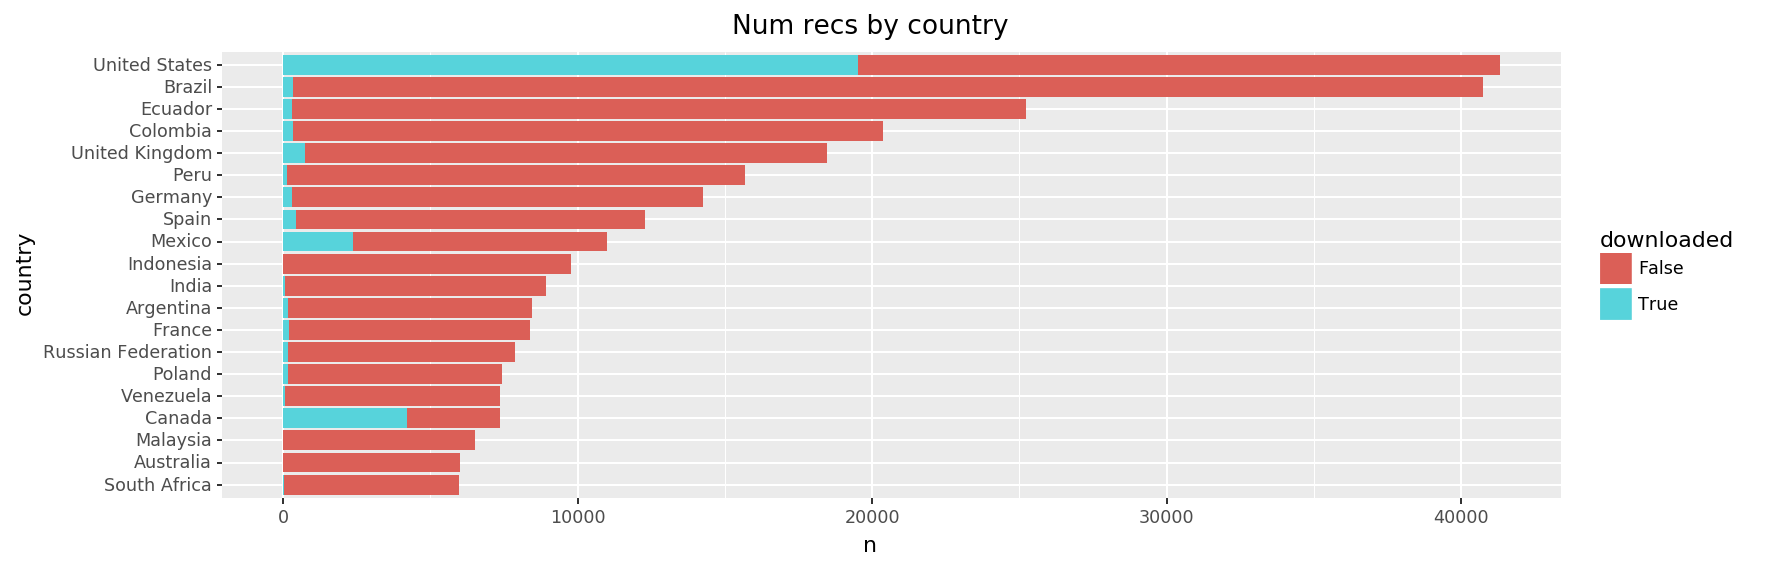

<ggplot: (-9223372036550539881)>

In [ ]:
(xc.metadata
    .assign(n=1).groupby(['country', 'downloaded'])['n'].sum().reset_index()
    .pipe(df_ordered_cat, country=lambda df: df.groupby('country')['n'].sum().reset_index().sort_values('n').country.unique())
    .sort_values('country')[-int(20 * 2):]  # Inflate for downloaded=(True|False)
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='country', y='n', fill='downloaded'))
    + geom_bar(stat='identity')
    + coord_flip()
    + theme_figsize('inline_short')
    + ggtitle('Num recs by country')
)

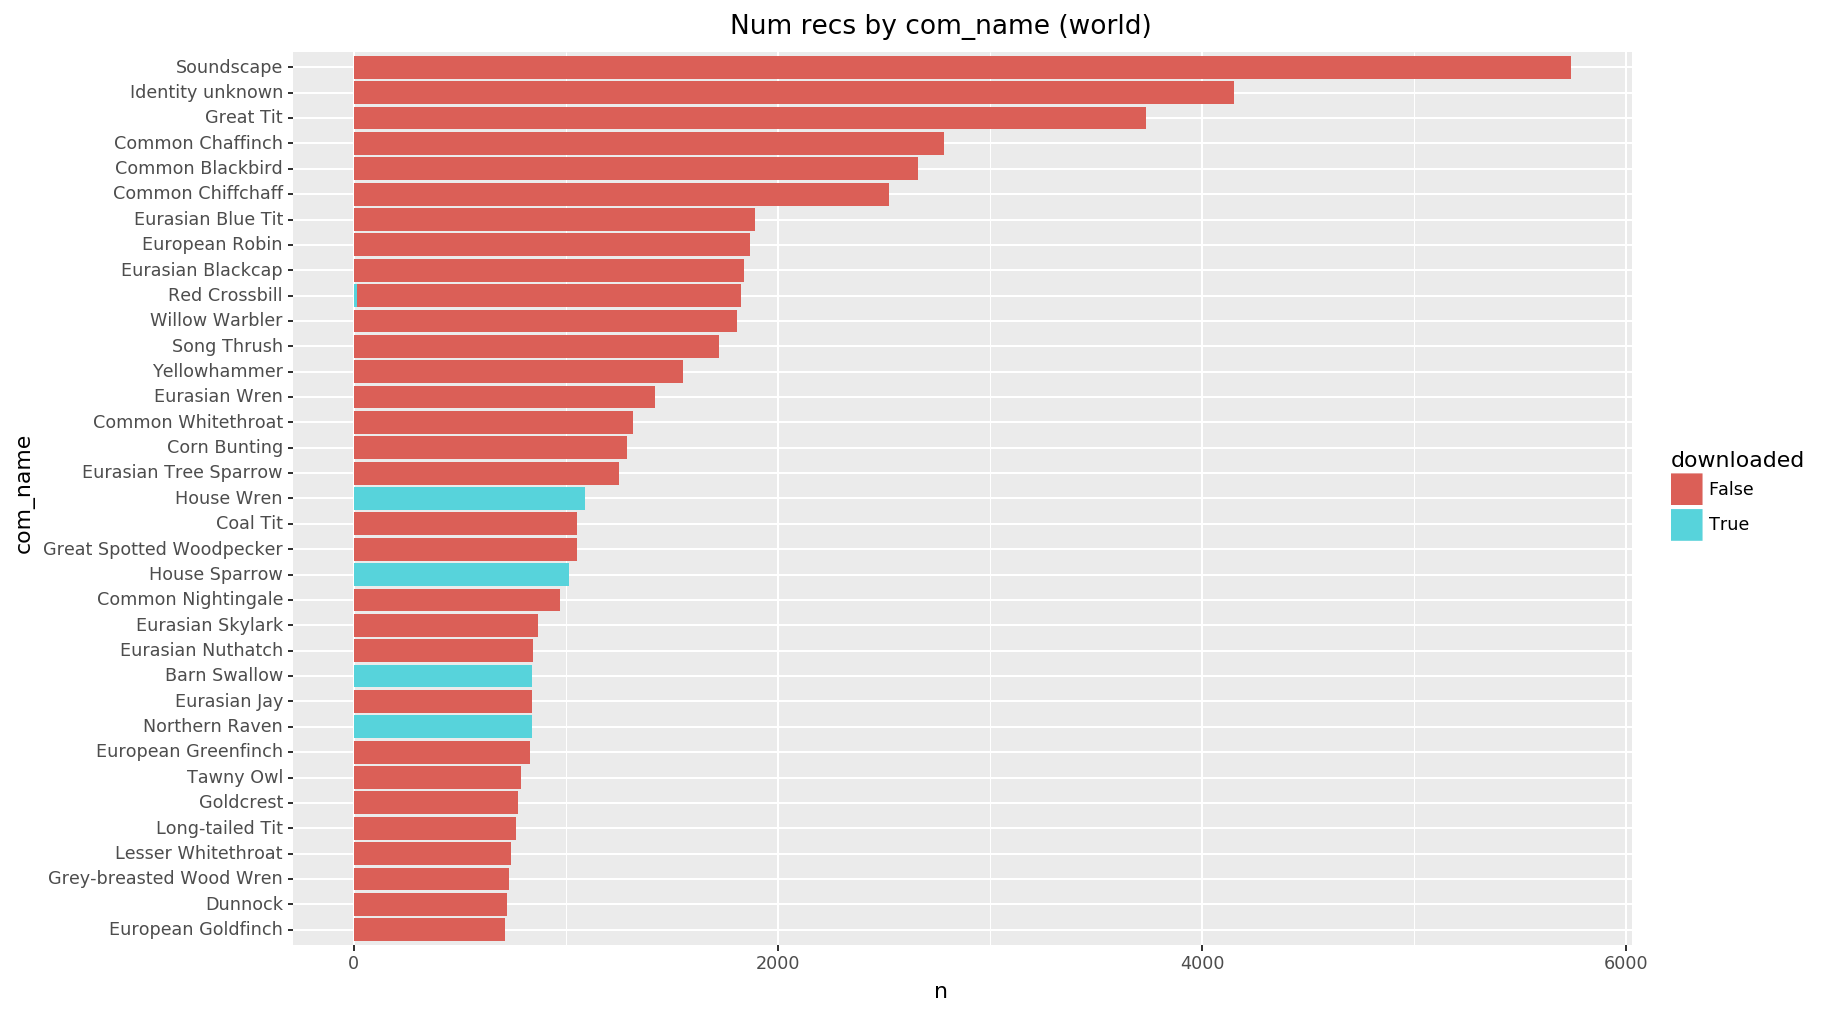

<ggplot: (-9223372036526282229)>

In [ ]:
(xc.metadata
    .assign(n=1).groupby(['com_name', 'downloaded'])['n'].sum().reset_index()
    .pipe(df_ordered_cat, com_name=lambda df: df.groupby('com_name')['n'].sum().reset_index().sort_values('n').com_name.unique())
    .sort_values('com_name')[-int(30 * 1.2):]  # Inflate for downloaded=(True|False)
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='com_name', y='n', fill='downloaded'))
    + geom_bar(stat='identity')
    + coord_flip()
    + theme_figsize('inline')
    + ggtitle('Num recs by com_name (world)')
)

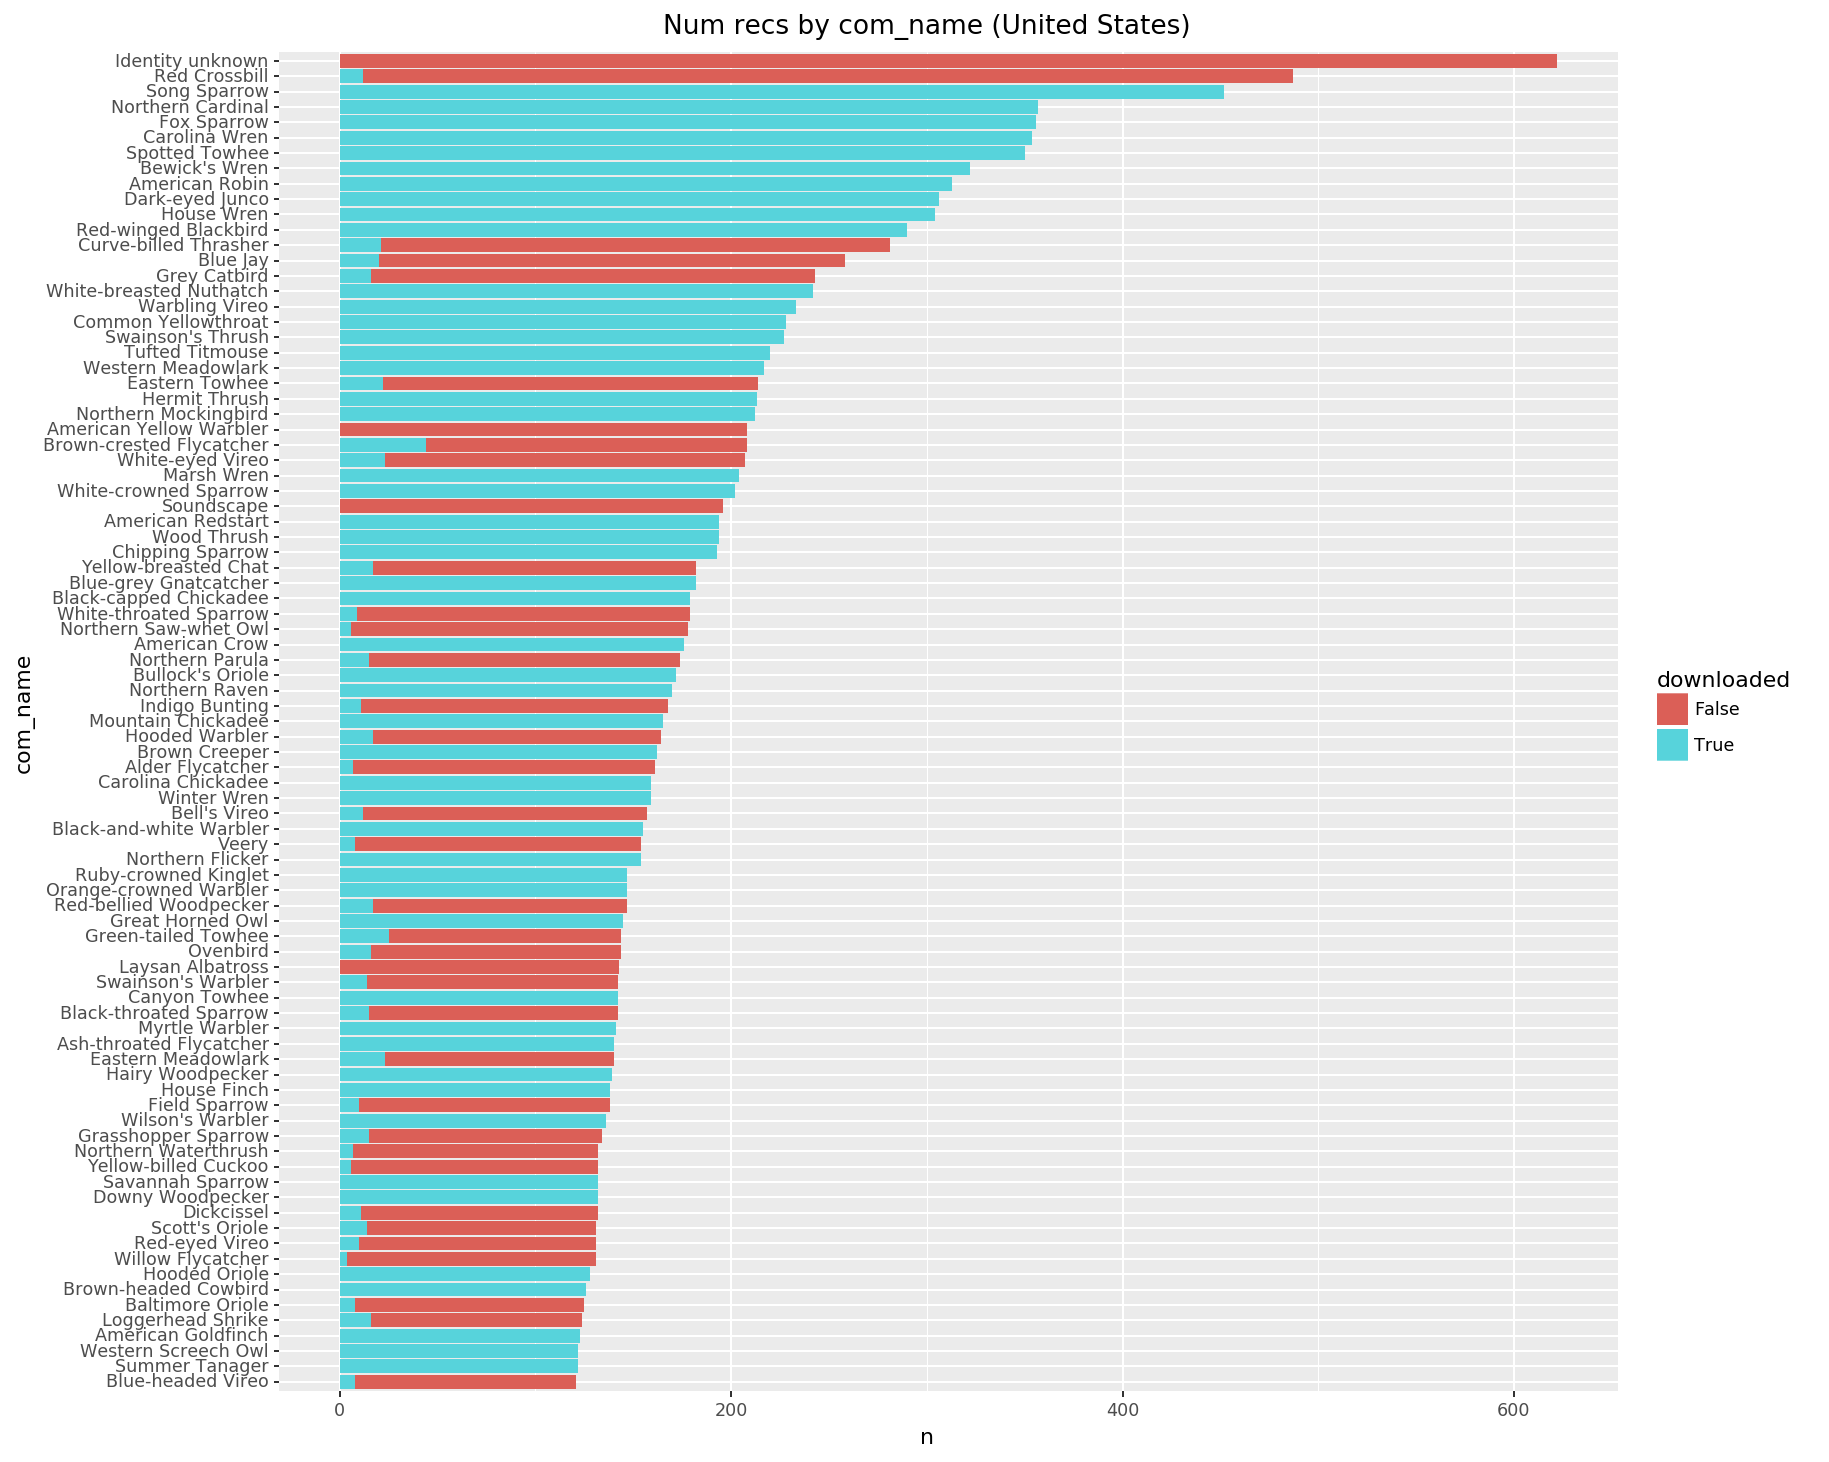

<ggplot: (-9223372036526271102)>

In [ ]:
(xc.metadata
    [lambda df: df.country == 'United States']
    .assign(n=1).groupby(['com_name', 'downloaded'])['n'].sum().reset_index()
    .pipe(df_ordered_cat, com_name=lambda df: df.groupby('com_name')['n'].sum().reset_index().sort_values('n').com_name.unique())
    .sort_values('com_name')[-int(60 * 2):]  # Inflate for downloaded=(True|False)
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='com_name', y='n', fill='downloaded'))
    + geom_bar(stat='identity')
    + coord_flip()
    + theme_figsize('square')
    + ggtitle('Num recs by com_name (United States)')
)

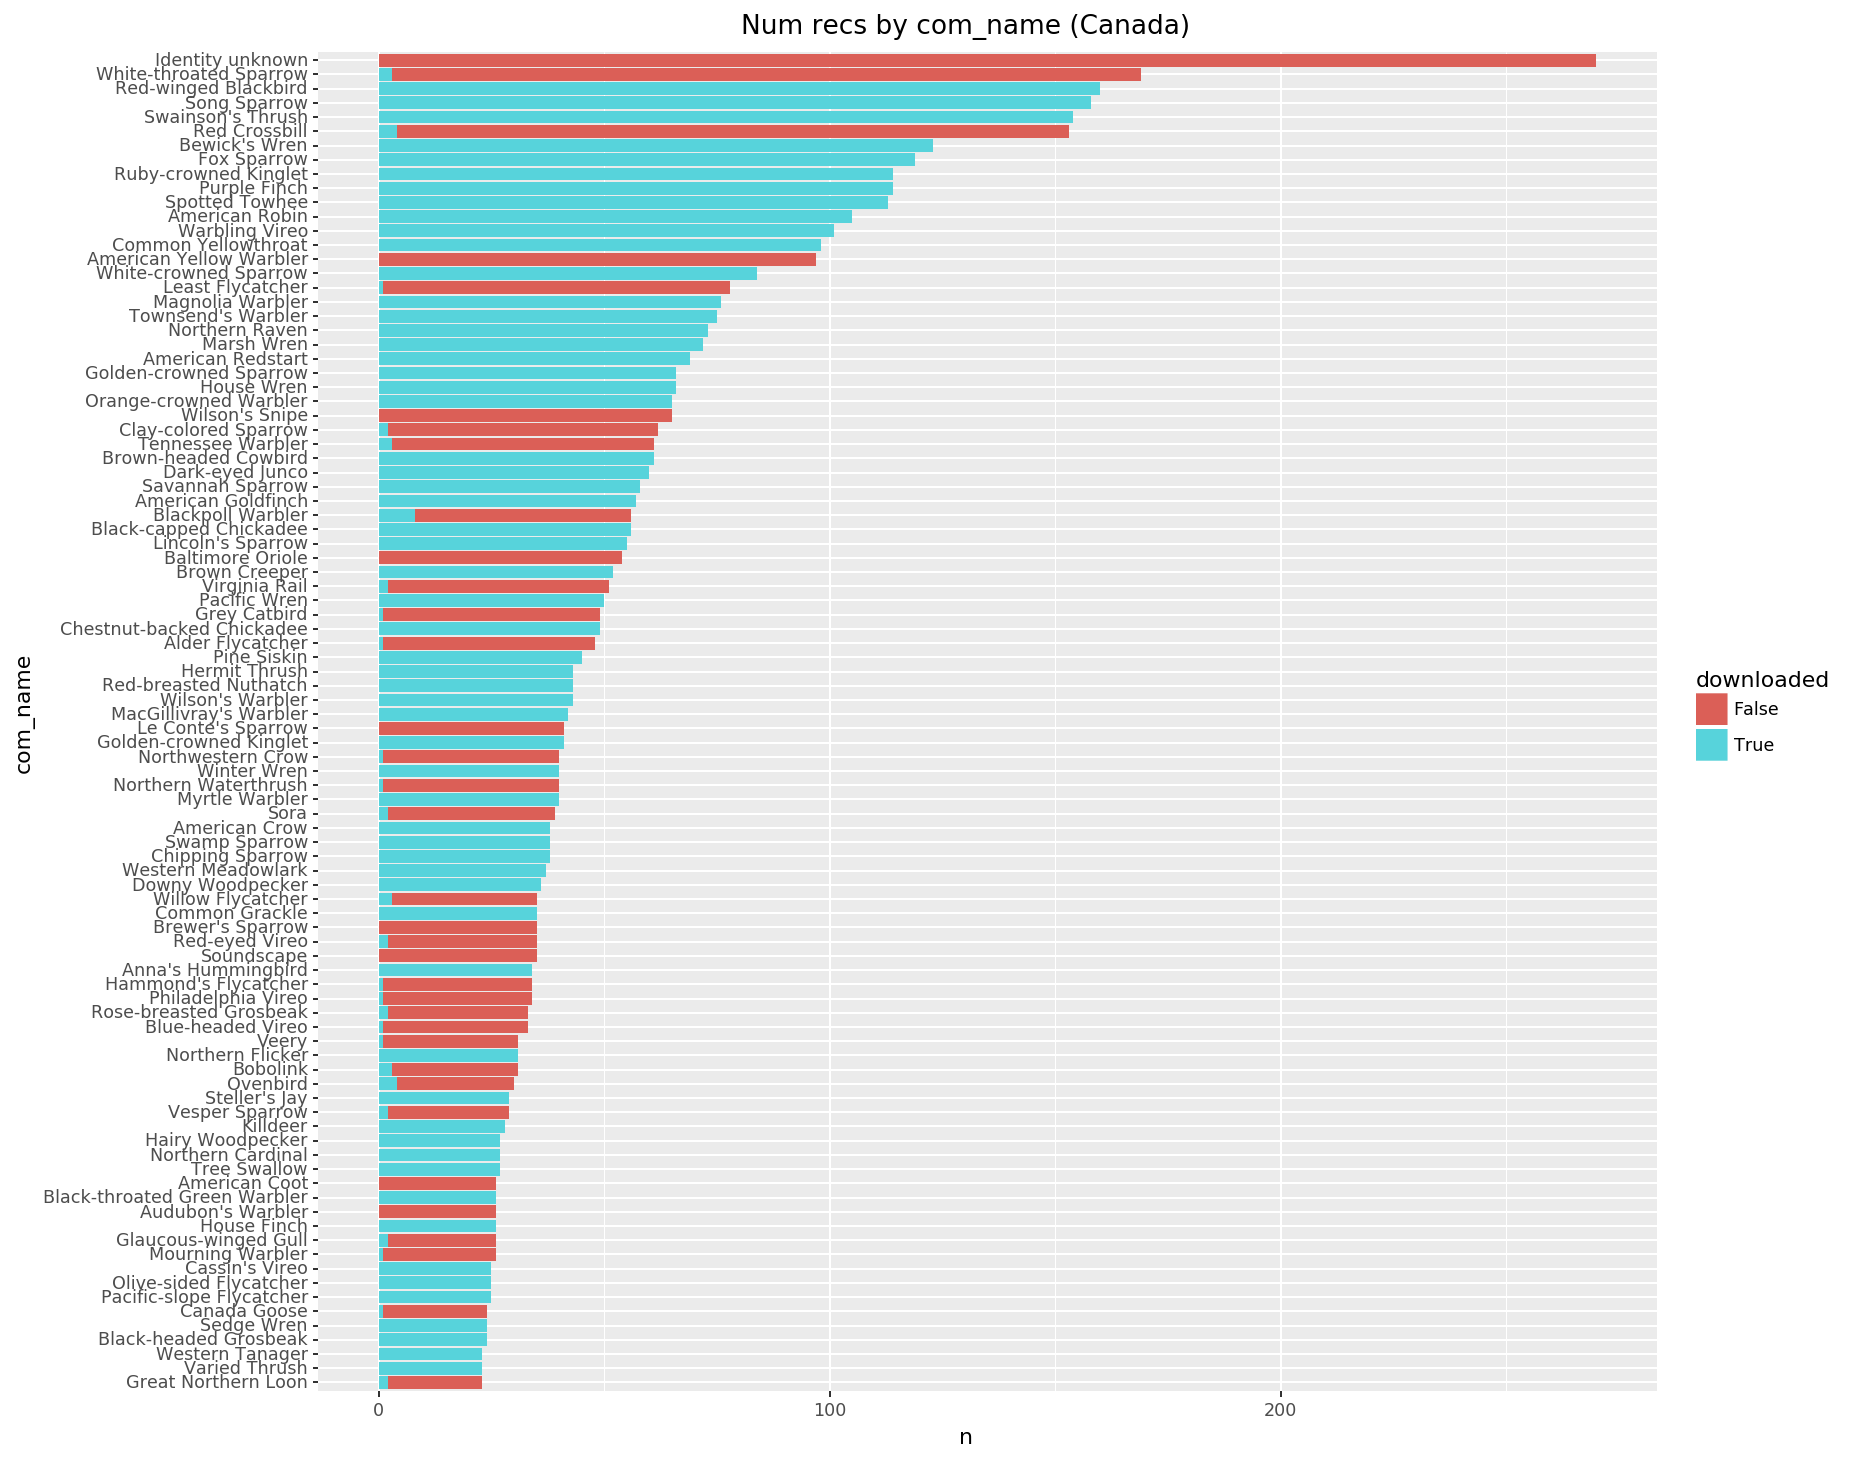

<ggplot: (322165845)>

In [ ]:
(xc.metadata
    [lambda df: df.country == 'Canada']
    .assign(n=1).groupby(['com_name', 'downloaded'])['n'].sum().reset_index()
    .pipe(df_ordered_cat, com_name=lambda df: df.groupby('com_name')['n'].sum().reset_index().sort_values('n').com_name.unique())
    .sort_values('com_name')[-int(60 * 2):]  # Inflate for downloaded=(True|False)
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='com_name', y='n', fill='downloaded'))
    + geom_bar(stat='identity')
    + coord_flip()
    + theme_figsize('square')
    + ggtitle('Num recs by com_name (Canada)')
)

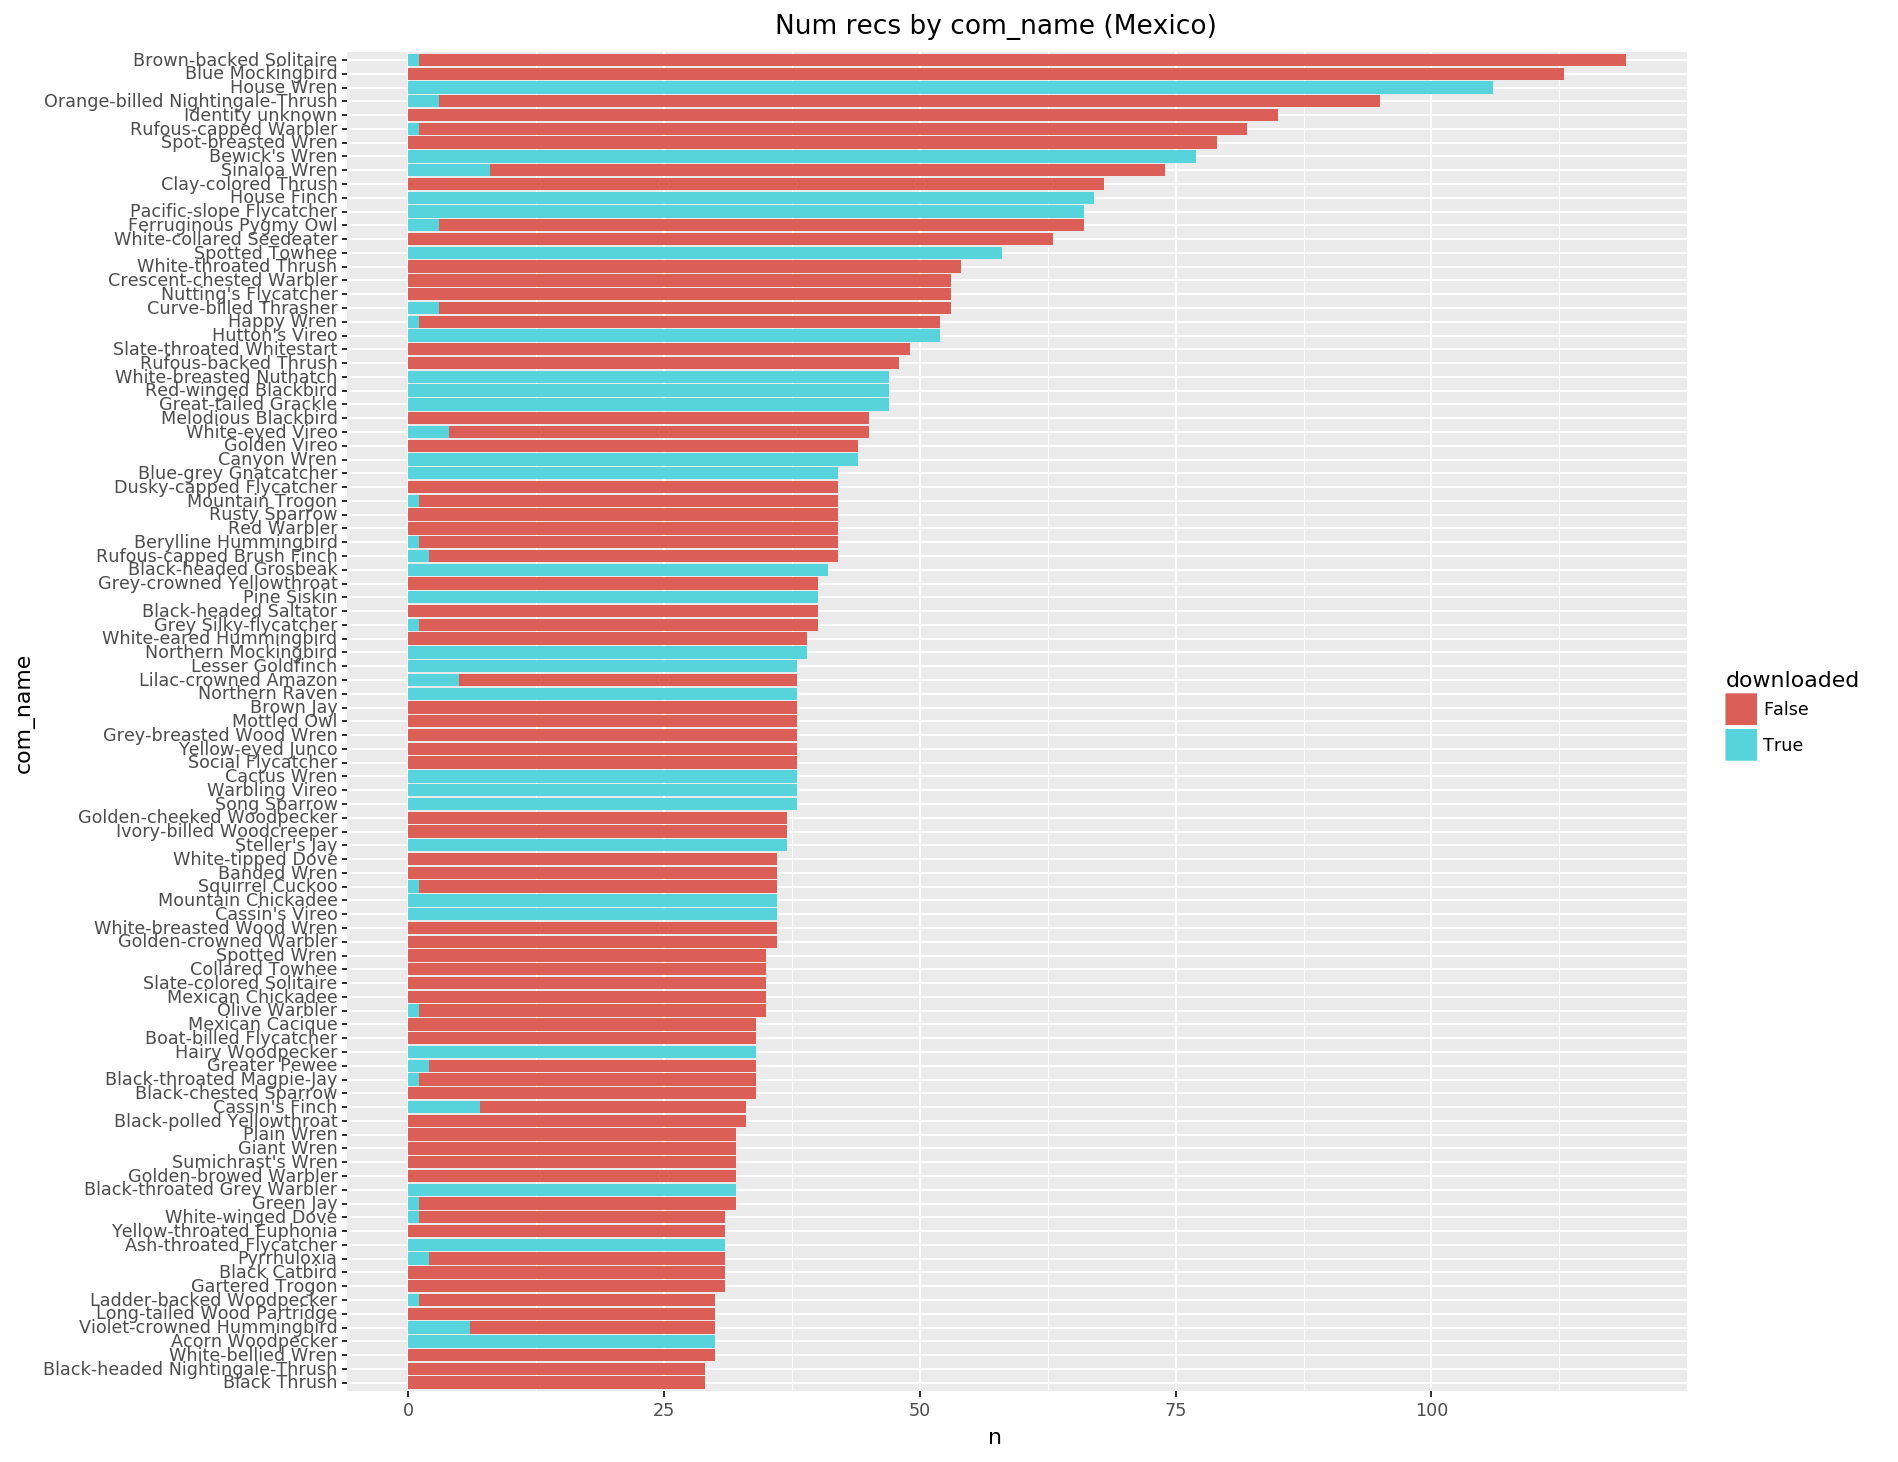

<ggplot: (-9223372036537485617)>

In [ ]:
(xc.metadata
    [lambda df: df.country == 'Mexico']
    .assign(n=1).groupby(['com_name', 'downloaded'])['n'].sum().reset_index()
    .pipe(df_ordered_cat, com_name=lambda df: df.groupby('com_name')['n'].sum().reset_index().sort_values('n').com_name.unique())
    .sort_values('com_name')[-int(60 * 2):]  # Inflate for downloaded=(True|False)
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='com_name', y='n', fill='downloaded'))
    + geom_bar(stat='identity')
    + coord_flip()
    + theme_figsize('square')
    + ggtitle('Num recs by com_name (Mexico)')
)

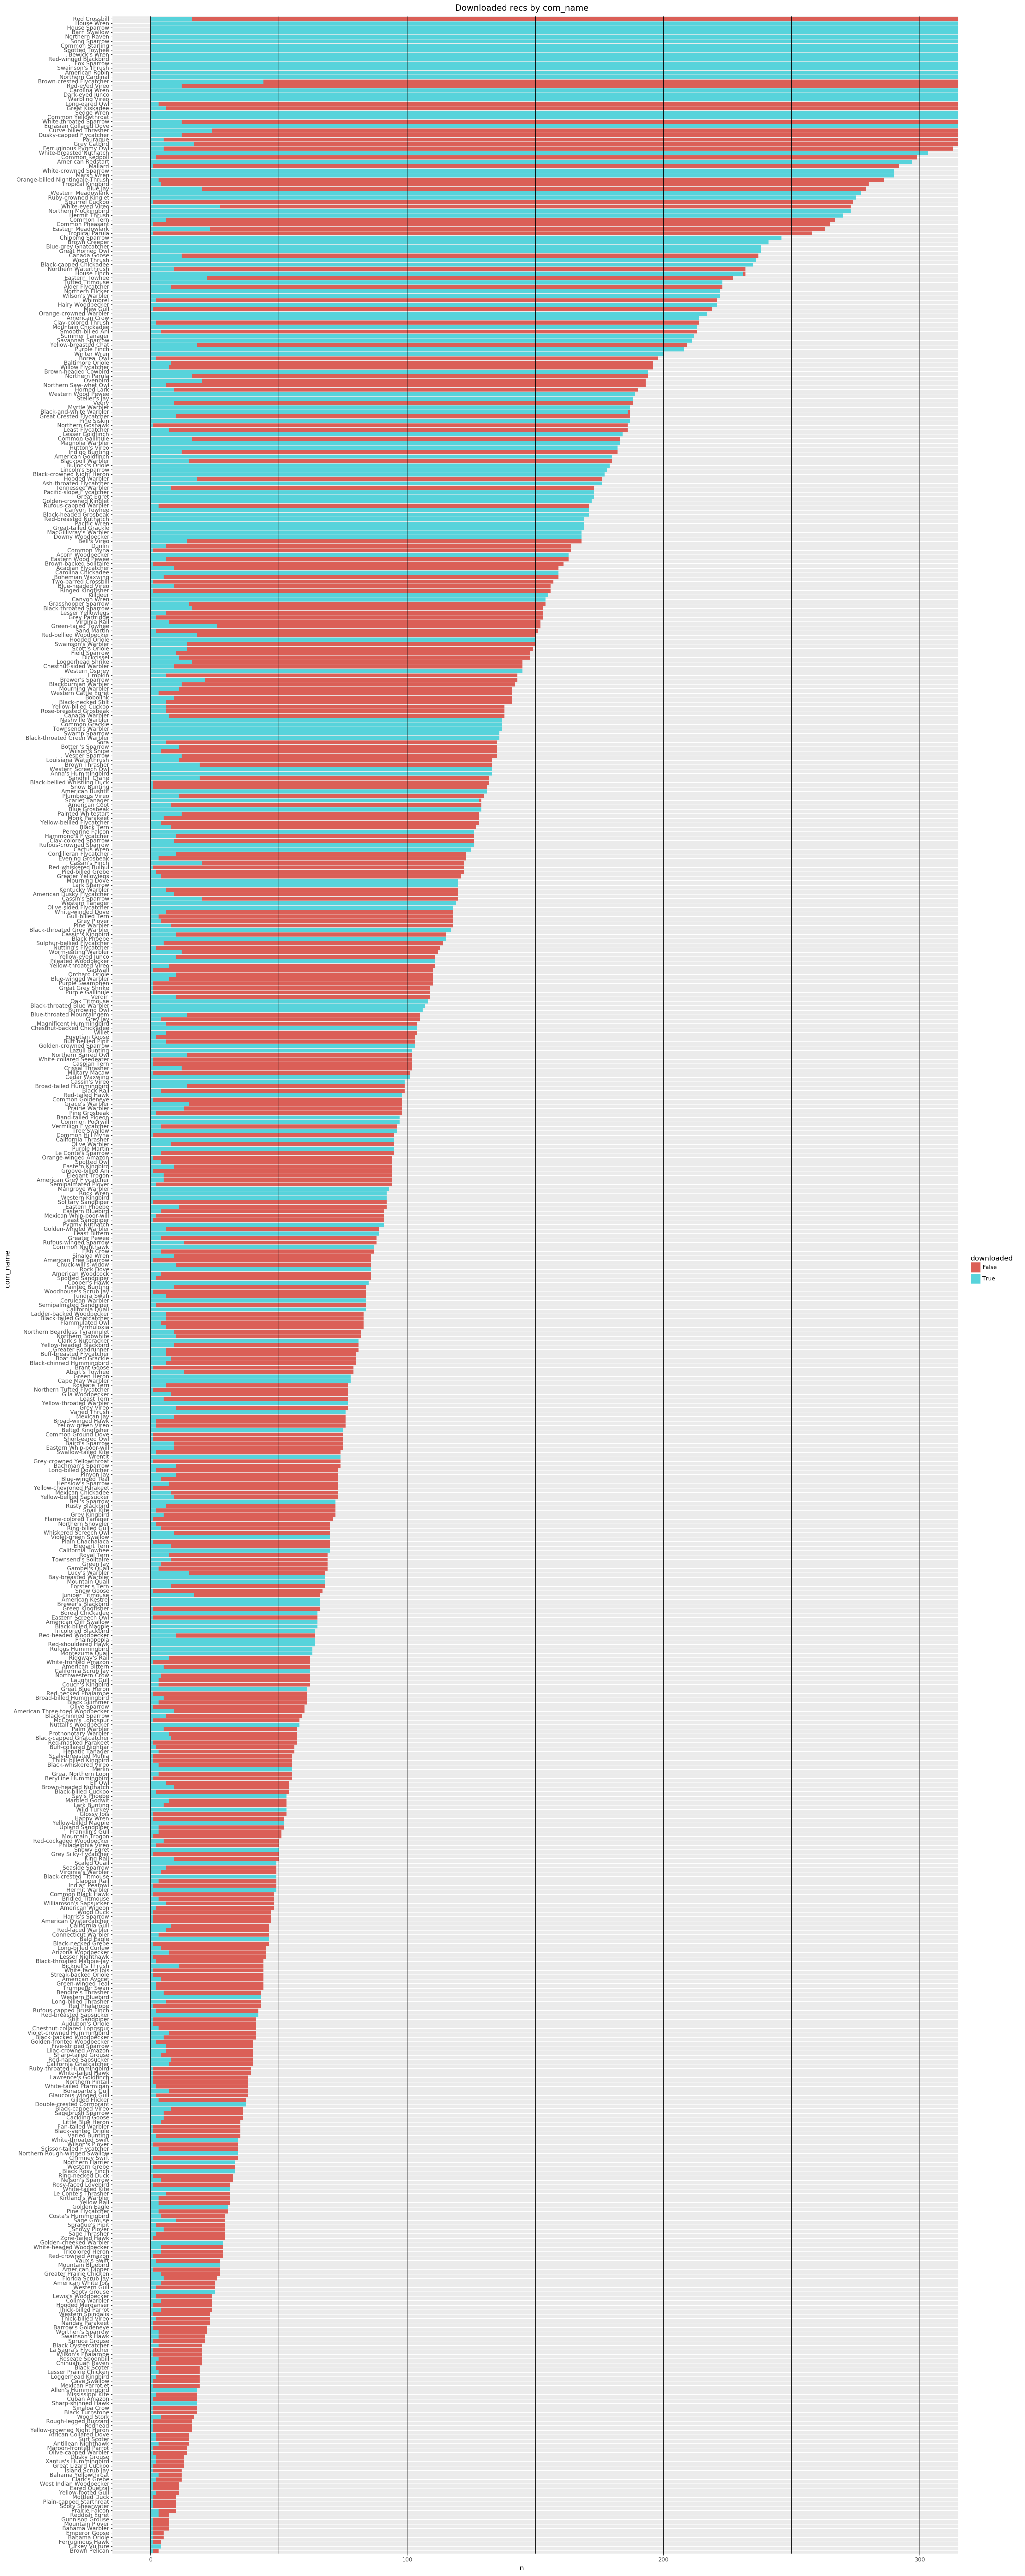

<ggplot: (-9223372036536735947)>

In [ ]:
(xc.metadata
    .pipe(df_cat_to_str)  # Removing _all_ cats (not just com_name) speeds up the groupby by ~2x [why?]
    .groupby(['com_name']).filter(lambda g: True in g.downloaded.values)  # Exclude com_name's with no downloads
    .assign(n=1).groupby(['com_name', 'downloaded'])['n'].sum().reset_index()
    .pipe(df_ordered_cat, com_name=lambda df: df.groupby('com_name')['n'].sum().reset_index().sort_values('n').com_name.unique())
    .sort_values('com_name')
    [:1000]  # Plot "everything", but stop at some point
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='com_name', y='n', fill='downloaded'))
    + geom_bar(stat='identity')
    + plotnine.layer.Layers([
        geom_hline(yintercept=yintercept, color='black')
        for yintercept in range(0, 1000, 50)
    ])
    # Zoom the x-axis in on the downloaded fraction
    # + coord_flip()
    # + coord_flip(ylim=(0, 100))
    # + coord_flip(ylim=(0, 200))
    + coord_flip(ylim=(0, 300))
    # Figsize to fit the y-axis (com_name)
    # + theme_figsize(width=12, aspect_ratio=1/1)  # square
    + theme_figsize(width=24, aspect_ratio=3.0/1)
    # + theme_figsize(width=12*1, aspect_ratio=8/3)  # half
    # + theme_figsize(width=12*2, aspect_ratio=8/6)  # full
    + ggtitle('Downloaded recs by com_name')
)

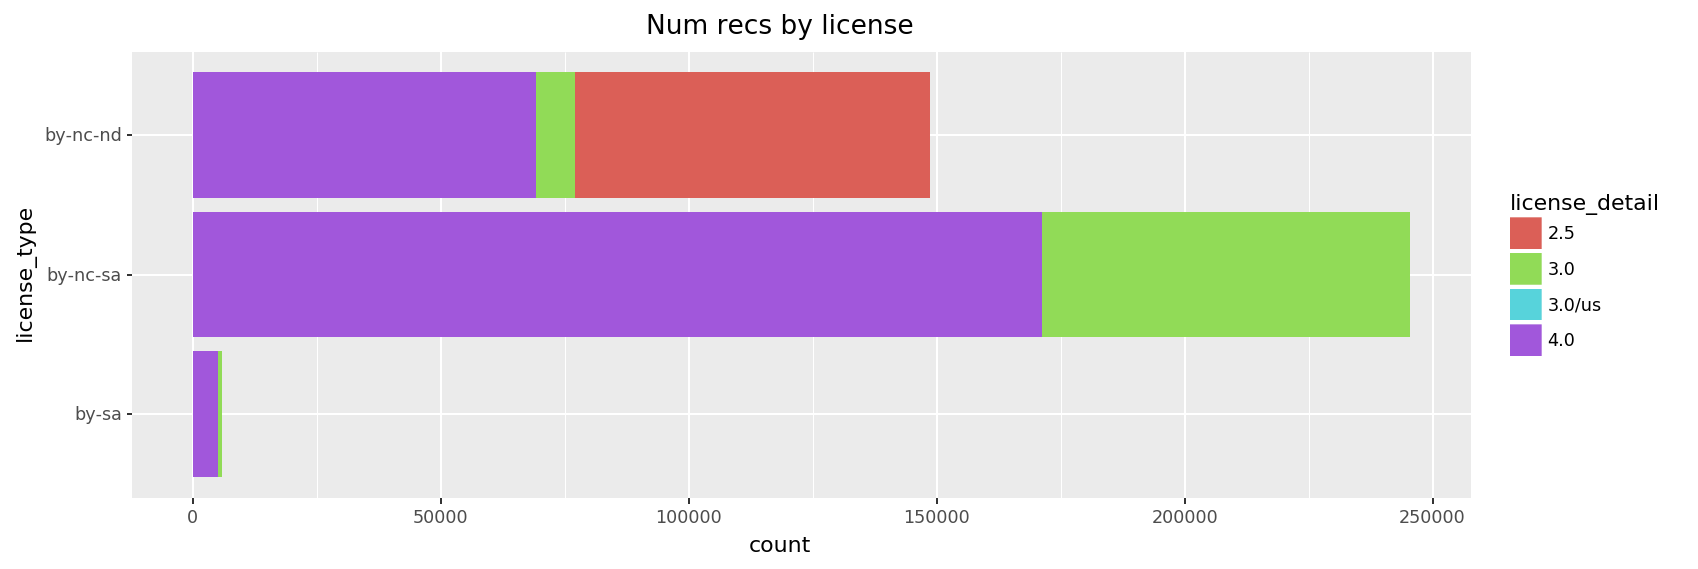

<ggplot: (-9223372036550458189)>

In [ ]:
(xc.metadata
    .pipe(df_reverse_cat, 'license_type')
    .pipe(ggplot, aes(x='license_type', fill='license_detail'))
    + geom_bar()
    + coord_flip()
    + ggtitle('Num recs by license')
)

In [ ]:
# Rec date vs. XC id (by country)
#   - [Interesting but not actionable]
# (xc.metadata
#     .fillna({'date': pd.to_datetime('2000-01-01')}) # plotnine barfs on NaT
#     .sample(20_000, random_state=0)
#     .assign(color=lambda df: df.country.map(lambda x: x if x in [
#         'United States',
#         'Brazil',
#         'Ecuador',
#         'Colombia',
#         'United Kingdom',
#         'Peru',
#         'Germany',
#         'Spain',
#         'Mexico',
#         # 'Indonesia',
#         # 'India',
#     ] else 'other'))
#     .pipe(ggplot, aes(x='id', y='date', color='color'))
#     + geom_point(alpha=.2)
#     + scale_color_cmap_d(mpl.cm.tab10)
#     + theme_figsize('square')
#     + ggtitle('Rec date vs. XC id (by country)')
# )

In [ ]:
%%R -o worldmap
# Get worldmap shapes from R
suppressMessages(library(rnaturalearth))
worldmap_raw <- ne_coastline(scale = "small")
{{worldmap_raw@data$id <- row.names(worldmap_raw@data)}}
worldmap <- dplyr::left_join(broom::tidy(worldmap_raw), worldmap_raw@data, by = 'id')

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin_2d : Removed 17969 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


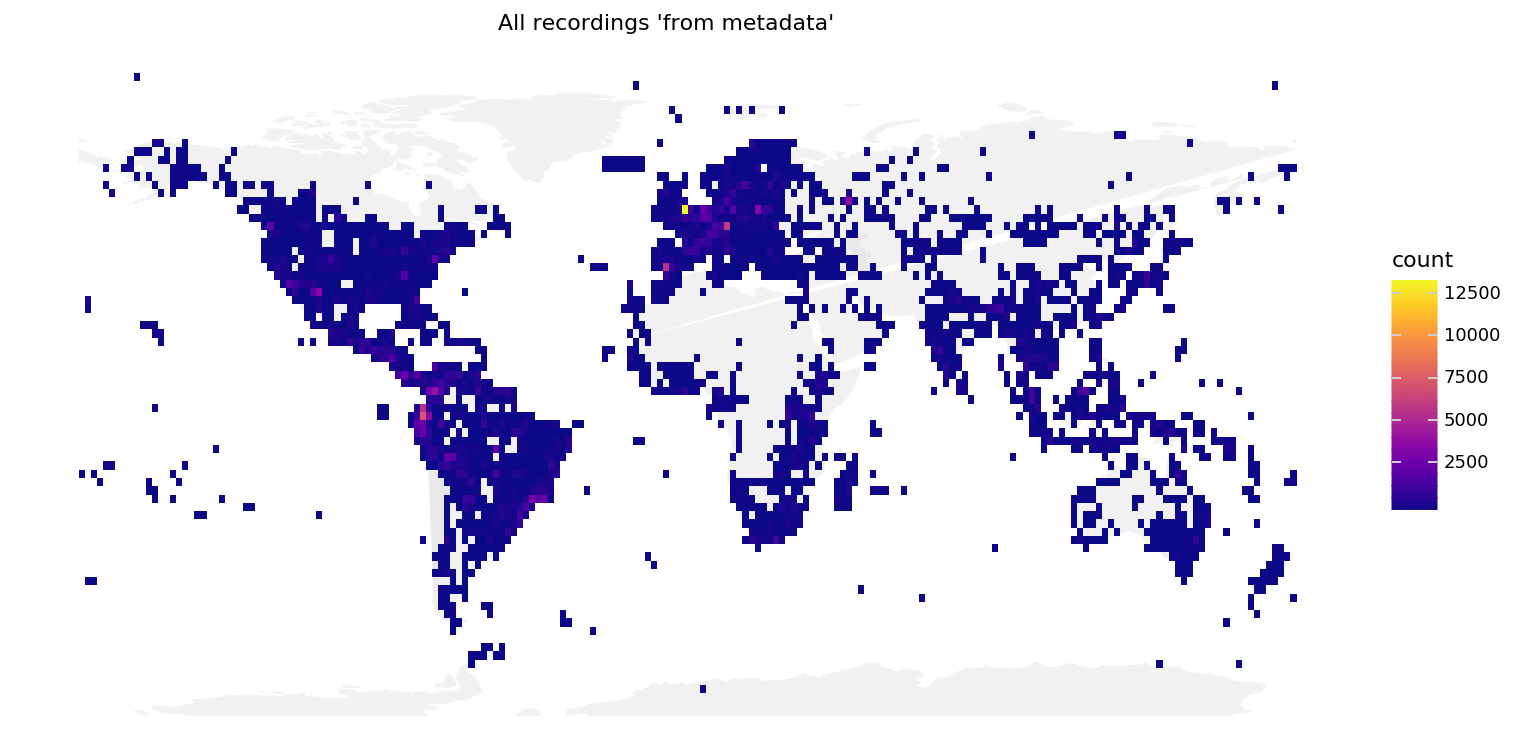

<ggplot: (289907383)>

In [ ]:
xc.metadata.pipe(lambda df: (df
    .pipe(ggplot, aes(x='lng', y='lat'))
    + geom_polygon(aes(x='long', y='lat', group='group'), data=worldmap, alpha=.3, fill='lightgray')
    + geom_bin2d(bins=np.array([5, 2]) * 40)
    + coord_cartesian(xlim=(df.lng.min(), df.lng.max()), ylim=(df.lat.min(), df.lat.max()))
    + scale_fill_cmap(mpl.cm.plasma)
    + theme_void()
    + theme_figsize(width=12, aspect_ratio=1/2)
    + ggtitle("All recordings 'from metadata'")
))

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin_2d : Removed 619 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


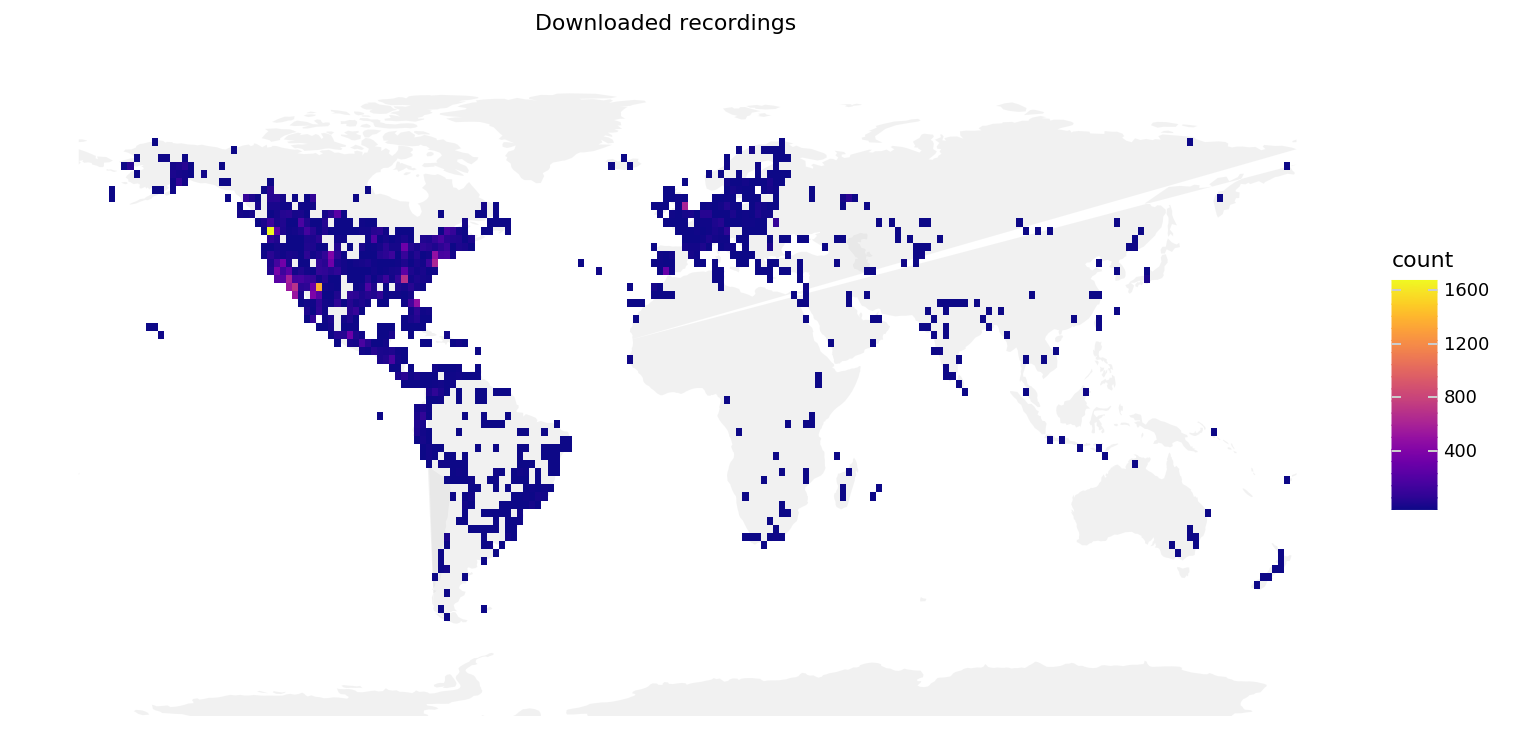

<ggplot: (314118127)>

In [ ]:
xc.metadata.pipe(lambda df: (df
    [lambda df: df.downloaded]
    .pipe(ggplot, aes(x='lng', y='lat'))
    + geom_polygon(aes(x='long', y='lat', group='group'), data=worldmap, alpha=.3, fill='lightgray')
    + geom_bin2d(bins=np.array([5, 2]) * 40)
    + coord_cartesian(xlim=(df.lng.min(), df.lng.max()), ylim=(df.lat.min(), df.lat.max()))
    + scale_fill_cmap(mpl.cm.plasma)
    + theme_void()
    + theme_figsize(width=12, aspect_ratio=1/2)
    + ggtitle('Downloaded recordings')
))

In [ ]:
# Prep for the next plot (separated so that its ~4s runtime isn't in the dev loop)
_df = (xc.metadata
    [lambda df: df.downloaded]
    .astype({'species': 'str', 'com_name': 'str'})  # Else groupby is really slow [why?]
    .groupby(['species', 'com_name']).apply(lambda g: g.assign(n=len(g)))
    .sort_values(['n', 'species', 'com_name'], ascending=False)
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin_2d : Removed 478 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


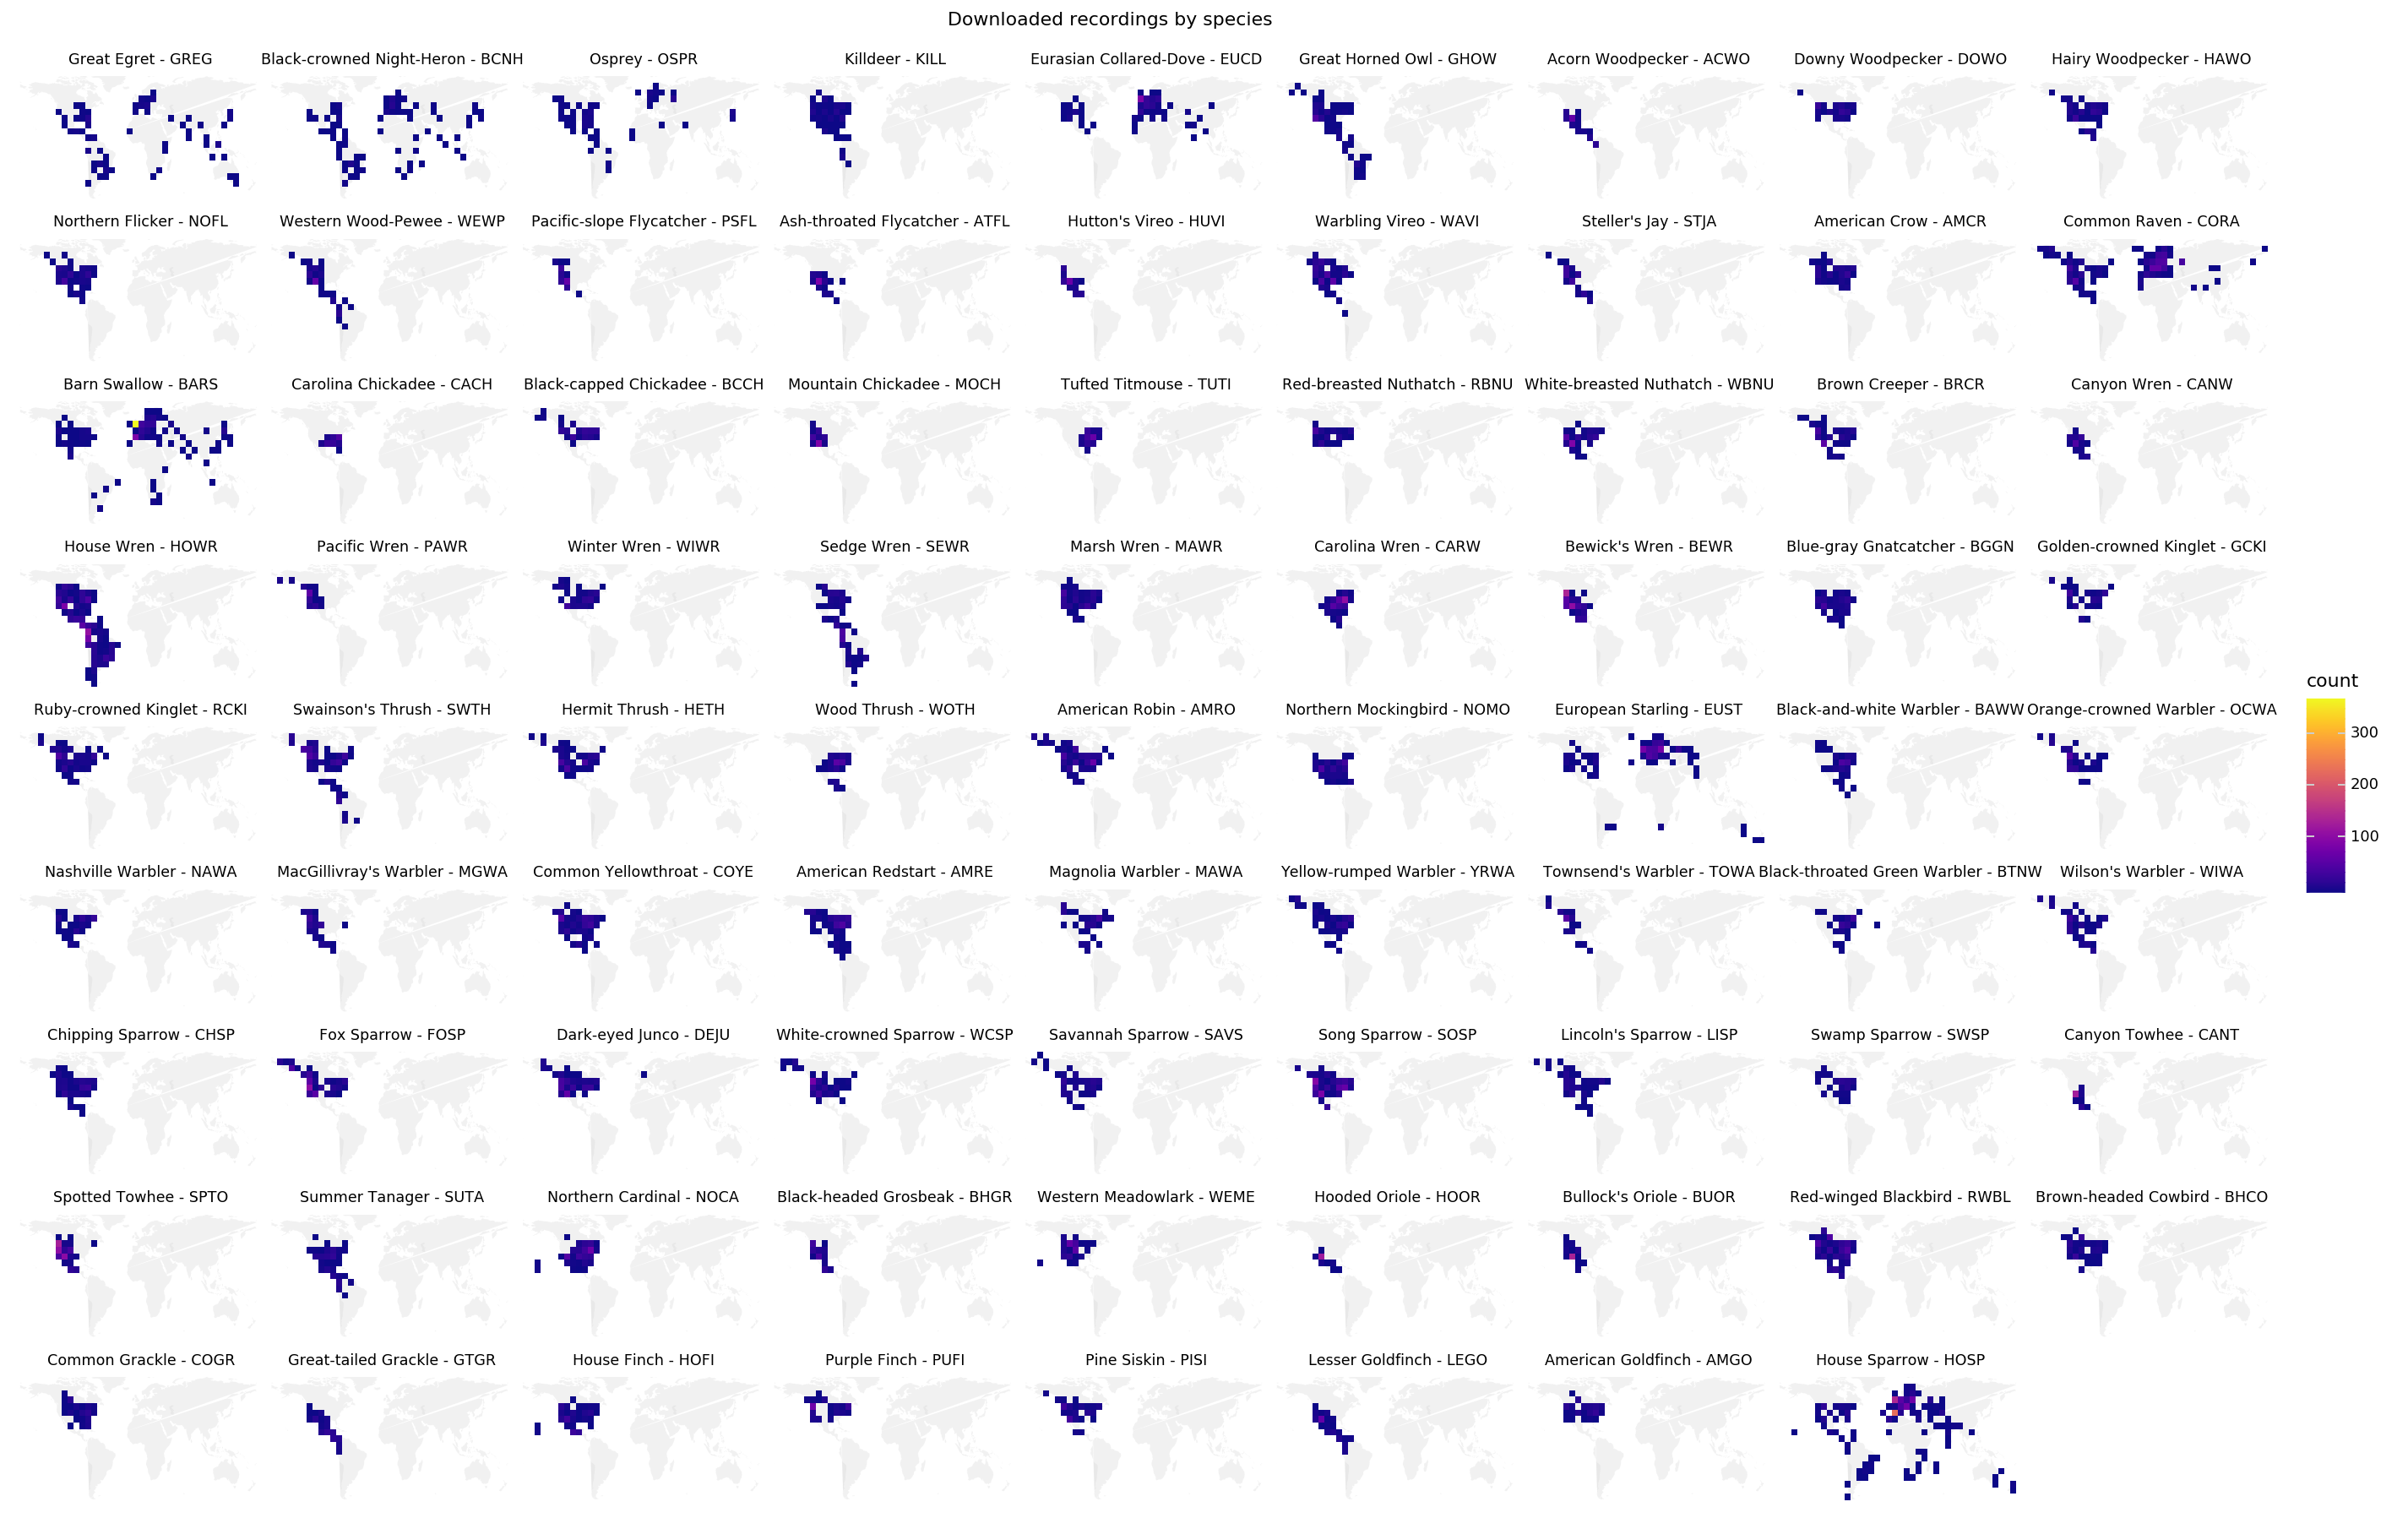

<ggplot: (-9223372036524156265)>

In [ ]:
_df.pipe(lambda df: (df
    # [lambda df: df.species.isin(df.species.unique()[:4])]  # Faster dev
    [lambda df: df.species.isin(df.species.unique()[:80])]  # Top species by num recs
    # Join in .longhand from metadata.species (xc.metadata.com_name is too dirty to synthesize it ourselves, e.g. "Northern Raven - CORA")
    .set_index('species')
    .join(
        metadata.species.df.rename(columns={'shorthand': 'species'})[['species', 'longhand']].set_index('species'),
        how='left',
    )
    .reset_index()
    # Pick column to facet on
    .assign(facet=lambda df: df.longhand)
    # .pipe(df_ordered_cat, facet=lambda df: df.facet.unique())  # Sort species by num recs
    .pipe(ggplot, aes(x='lng', y='lat'))
    + facet_wrap('facet')
    + geom_polygon(aes(x='long', y='lat', group='group'), data=worldmap, alpha=.3, fill='lightgray')
    + geom_bin2d(bins=np.array([5, 3]) * 8)  # [w,h]
    + scale_fill_cmap(mpl.cm.plasma)
    + coord_cartesian(xlim=(df.lng.min(), df.lng.max()), ylim=(df.lat.min(), df.lat.max()))
    + theme_void()
    + theme_figsize(width=24, aspect_ratio=1/2)
    + ggtitle('Downloaded recordings by species')
))